# Marching Cubes Implementation and Visualization

Marching Cubes is an algorithm by William E. Lorensen and Harvey E. Cline at General Electric Medical to extract Polygonal Mesh of an isosurface from scalar field on three dimensional grid (Source: Wikipedia). Its predemoninatly used in Medical Imaging to visualize data from CT and MRI devices (Source: Lecture Notes).

Sv ={(x,y,x)|f(x,y,z) = V} (Source: Lecture Notes) Where Sv is the scalar volume and V is the value.

For implementation, we follow the steps as outlined in the text "Isosurfaces : geometry, topology, and algorithm  Wenger, Rephael.Boca Raton" (see the screenshot below) and lecture notes by Prof Eric Shaffer.
1. Build a Triangle Lookup table
2. Label each vertex as greater than or less than isovalue using 8 bit code.
3. Retrieve the Isosurface triangles by looking up the triangle table using the 8 bit code  
4. Determine the vertices on the bipolar edge using Linear Interpolation and populate the vertex array.
5. Populate the triangle array using the vertices generated in step 4.
6. Visualize the data using Pyvista Unstructured grid for triangular faces and vertices.
7. Compare the Visualizations generated by our implementation with the one generated by the standard marching cubes API.

Performance Optimization (Source: Prof Eric Shaffer's lecture notes) - We have used map data structure to optimize the interpolations for the same bipolar edge - Avoid computing one vertex multiple times. We essentially compute the vertex location once, and store it in the map. 

##### Requirements: Please install the following Python Libraries prior to running this file
1. pynrrd
2. matplotlib
3. pyvista
4. vtk
5. itkwidgets
5. scikit-image

##### Downloads: Please download the CTA-cardio.nrrd file from Slicer (https://www.slicer.org/wiki/File:CTA-cardio.nrrd)

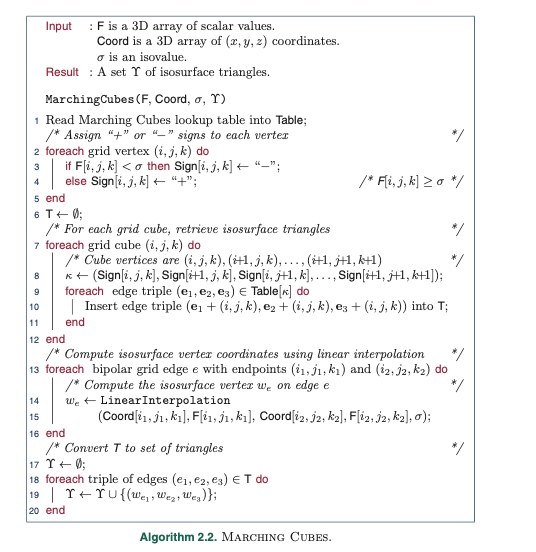
(Source: Isosurfaces : geometry, topology, and algorithm  Wenger, Rephael.Boca Raton)


In [ ]:
#import Python Libraries
import numpy as np
import nrrd
import matplotlib.pyplot as plt
import time


In [ ]:
#Build Marching Cubes Lookup table
#This table is straight from Paul Bourke's site (Source: http://paulbourke.net/geometry/polygonise/)

triTable =[
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 8, 3, 9, 8, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, 1, 2, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 2, 10, 0, 2, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [2, 8, 3, 2, 10, 8, 10, 9, 8, -1, -1, -1, -1, -1, -1, -1],
            [3, 11, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 11, 2, 8, 11, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 9, 0, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 11, 2, 1, 9, 11, 9, 8, 11, -1, -1, -1, -1, -1, -1, -1],
            [3, 10, 1, 11, 10, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 10, 1, 0, 8, 10, 8, 11, 10, -1, -1, -1, -1, -1, -1, -1],
            [3, 9, 0, 3, 11, 9, 11, 10, 9, -1, -1, -1, -1, -1, -1, -1],
            [9, 8, 10, 10, 8, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 7, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 3, 0, 7, 3, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 1, 9, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 1, 9, 4, 7, 1, 7, 3, 1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 4, 7, 3, 0, 4, 1, 2, 10, -1, -1, -1, -1, -1, -1, -1],
            [9, 2, 10, 9, 0, 2, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1],
            [2, 10, 9, 2, 9, 7, 2, 7, 3, 7, 9, 4, -1, -1, -1, -1],
            [8, 4, 7, 3, 11, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [11, 4, 7, 11, 2, 4, 2, 0, 4, -1, -1, -1, -1, -1, -1, -1],
            [9, 0, 1, 8, 4, 7, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1],
            [4, 7, 11, 9, 4, 11, 9, 11, 2, 9, 2, 1, -1, -1, -1, -1],
            [3, 10, 1, 3, 11, 10, 7, 8, 4, -1, -1, -1, -1, -1, -1, -1],
            [1, 11, 10, 1, 4, 11, 1, 0, 4, 7, 11, 4, -1, -1, -1, -1],
            [4, 7, 8, 9, 0, 11, 9, 11, 10, 11, 0, 3, -1, -1, -1, -1],
            [4, 7, 11, 4, 11, 9, 9, 11, 10, -1, -1, -1, -1, -1, -1, -1],
            [9, 5, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 5, 4, 0, 8, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 5, 4, 1, 5, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [8, 5, 4, 8, 3, 5, 3, 1, 5, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, 9, 5, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 0, 8, 1, 2, 10, 4, 9, 5, -1, -1, -1, -1, -1, -1, -1],
            [5, 2, 10, 5, 4, 2, 4, 0, 2, -1, -1, -1, -1, -1, -1, -1],
            [2, 10, 5, 3, 2, 5, 3, 5, 4, 3, 4, 8, -1, -1, -1, -1],
            [9, 5, 4, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 11, 2, 0, 8, 11, 4, 9, 5, -1, -1, -1, -1, -1, -1, -1],
            [0, 5, 4, 0, 1, 5, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1],
            [2, 1, 5, 2, 5, 8, 2, 8, 11, 4, 8, 5, -1, -1, -1, -1],
            [10, 3, 11, 10, 1, 3, 9, 5, 4, -1, -1, -1, -1, -1, -1, -1],
            [4, 9, 5, 0, 8, 1, 8, 10, 1, 8, 11, 10, -1, -1, -1, -1],
            [5, 4, 0, 5, 0, 11, 5, 11, 10, 11, 0, 3, -1, -1, -1, -1],
            [5, 4, 8, 5, 8, 10, 10, 8, 11, -1, -1, -1, -1, -1, -1, -1],
            [9, 7, 8, 5, 7, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 3, 0, 9, 5, 3, 5, 7, 3, -1, -1, -1, -1, -1, -1, -1],
            [0, 7, 8, 0, 1, 7, 1, 5, 7, -1, -1, -1, -1, -1, -1, -1],
            [1, 5, 3, 3, 5, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 7, 8, 9, 5, 7, 10, 1, 2, -1, -1, -1, -1, -1, -1, -1],
            [10, 1, 2, 9, 5, 0, 5, 3, 0, 5, 7, 3, -1, -1, -1, -1],
            [8, 0, 2, 8, 2, 5, 8, 5, 7, 10, 5, 2, -1, -1, -1, -1],
            [2, 10, 5, 2, 5, 3, 3, 5, 7, -1, -1, -1, -1, -1, -1, -1],
            [7, 9, 5, 7, 8, 9, 3, 11, 2, -1, -1, -1, -1, -1, -1, -1],
            [9, 5, 7, 9, 7, 2, 9, 2, 0, 2, 7, 11, -1, -1, -1, -1],
            [2, 3, 11, 0, 1, 8, 1, 7, 8, 1, 5, 7, -1, -1, -1, -1],
            [11, 2, 1, 11, 1, 7, 7, 1, 5, -1, -1, -1, -1, -1, -1, -1],
            [9, 5, 8, 8, 5, 7, 10, 1, 3, 10, 3, 11, -1, -1, -1, -1],
            [5, 7, 0, 5, 0, 9, 7, 11, 0, 1, 0, 10, 11, 10, 0, -1],
            [11, 10, 0, 11, 0, 3, 10, 5, 0, 8, 0, 7, 5, 7, 0, -1],
            [11, 10, 5, 7, 11, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [10, 6, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 0, 1, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 8, 3, 1, 9, 8, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1],
            [1, 6, 5, 2, 6, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 6, 5, 1, 2, 6, 3, 0, 8, -1, -1, -1, -1, -1, -1, -1],
            [9, 6, 5, 9, 0, 6, 0, 2, 6, -1, -1, -1, -1, -1, -1, -1],
            [5, 9, 8, 5, 8, 2, 5, 2, 6, 3, 2, 8, -1, -1, -1, -1],
            [2, 3, 11, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [11, 0, 8, 11, 2, 0, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1],
            [0, 1, 9, 2, 3, 11, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1],
            [5, 10, 6, 1, 9, 2, 9, 11, 2, 9, 8, 11, -1, -1, -1, -1],
            [6, 3, 11, 6, 5, 3, 5, 1, 3, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 11, 0, 11, 5, 0, 5, 1, 5, 11, 6, -1, -1, -1, -1],
            [3, 11, 6, 0, 3, 6, 0, 6, 5, 0, 5, 9, -1, -1, -1, -1],
            [6, 5, 9, 6, 9, 11, 11, 9, 8, -1, -1, -1, -1, -1, -1, -1],
            [5, 10, 6, 4, 7, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 3, 0, 4, 7, 3, 6, 5, 10, -1, -1, -1, -1, -1, -1, -1],
            [1, 9, 0, 5, 10, 6, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1],
            [10, 6, 5, 1, 9, 7, 1, 7, 3, 7, 9, 4, -1, -1, -1, -1],
            [6, 1, 2, 6, 5, 1, 4, 7, 8, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 5, 5, 2, 6, 3, 0, 4, 3, 4, 7, -1, -1, -1, -1],
            [8, 4, 7, 9, 0, 5, 0, 6, 5, 0, 2, 6, -1, -1, -1, -1],
            [7, 3, 9, 7, 9, 4, 3, 2, 9, 5, 9, 6, 2, 6, 9, -1],
            [3, 11, 2, 7, 8, 4, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1],
            [5, 10, 6, 4, 7, 2, 4, 2, 0, 2, 7, 11, -1, -1, -1, -1],
            [0, 1, 9, 4, 7, 8, 2, 3, 11, 5, 10, 6, -1, -1, -1, -1],
            [9, 2, 1, 9, 11, 2, 9, 4, 11, 7, 11, 4, 5, 10, 6, -1],
            [8, 4, 7, 3, 11, 5, 3, 5, 1, 5, 11, 6, -1, -1, -1, -1],
            [5, 1, 11, 5, 11, 6, 1, 0, 11, 7, 11, 4, 0, 4, 11, -1],
            [0, 5, 9, 0, 6, 5, 0, 3, 6, 11, 6, 3, 8, 4, 7, -1],
            [6, 5, 9, 6, 9, 11, 4, 7, 9, 7, 11, 9, -1, -1, -1, -1],
            [10, 4, 9, 6, 4, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 10, 6, 4, 9, 10, 0, 8, 3, -1, -1, -1, -1, -1, -1, -1],
            [10, 0, 1, 10, 6, 0, 6, 4, 0, -1, -1, -1, -1, -1, -1, -1],
            [8, 3, 1, 8, 1, 6, 8, 6, 4, 6, 1, 10, -1, -1, -1, -1],
            [1, 4, 9, 1, 2, 4, 2, 6, 4, -1, -1, -1, -1, -1, -1, -1],
            [3, 0, 8, 1, 2, 9, 2, 4, 9, 2, 6, 4, -1, -1, -1, -1],
            [0, 2, 4, 4, 2, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [8, 3, 2, 8, 2, 4, 4, 2, 6, -1, -1, -1, -1, -1, -1, -1],
            [10, 4, 9, 10, 6, 4, 11, 2, 3, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 2, 2, 8, 11, 4, 9, 10, 4, 10, 6, -1, -1, -1, -1],
            [3, 11, 2, 0, 1, 6, 0, 6, 4, 6, 1, 10, -1, -1, -1, -1],
            [6, 4, 1, 6, 1, 10, 4, 8, 1, 2, 1, 11, 8, 11, 1, -1],
            [9, 6, 4, 9, 3, 6, 9, 1, 3, 11, 6, 3, -1, -1, -1, -1],
            [8, 11, 1, 8, 1, 0, 11, 6, 1, 9, 1, 4, 6, 4, 1, -1],
            [3, 11, 6, 3, 6, 0, 0, 6, 4, -1, -1, -1, -1, -1, -1, -1],
            [6, 4, 8, 11, 6, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [7, 10, 6, 7, 8, 10, 8, 9, 10, -1, -1, -1, -1, -1, -1, -1],
            [0, 7, 3, 0, 10, 7, 0, 9, 10, 6, 7, 10, -1, -1, -1, -1],
            [10, 6, 7, 1, 10, 7, 1, 7, 8, 1, 8, 0, -1, -1, -1, -1],
            [10, 6, 7, 10, 7, 1, 1, 7, 3, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 6, 1, 6, 8, 1, 8, 9, 8, 6, 7, -1, -1, -1, -1],
            [2, 6, 9, 2, 9, 1, 6, 7, 9, 0, 9, 3, 7, 3, 9, -1],
            [7, 8, 0, 7, 0, 6, 6, 0, 2, -1, -1, -1, -1, -1, -1, -1],
            [7, 3, 2, 6, 7, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [2, 3, 11, 10, 6, 8, 10, 8, 9, 8, 6, 7, -1, -1, -1, -1],
            [2, 0, 7, 2, 7, 11, 0, 9, 7, 6, 7, 10, 9, 10, 7, -1],
            [1, 8, 0, 1, 7, 8, 1, 10, 7, 6, 7, 10, 2, 3, 11, -1],
            [11, 2, 1, 11, 1, 7, 10, 6, 1, 6, 7, 1, -1, -1, -1, -1],
            [8, 9, 6, 8, 6, 7, 9, 1, 6, 11, 6, 3, 1, 3, 6, -1],
            [0, 9, 1, 11, 6, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [7, 8, 0, 7, 0, 6, 3, 11, 0, 11, 6, 0, -1, -1, -1, -1],
            [7, 11, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [7, 6, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 0, 8, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 1, 9, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [8, 1, 9, 8, 3, 1, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1],
            [10, 1, 2, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, 3, 0, 8, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1],
            [2, 9, 0, 2, 10, 9, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1],
            [6, 11, 7, 2, 10, 3, 10, 8, 3, 10, 9, 8, -1, -1, -1, -1],
            [7, 2, 3, 6, 2, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [7, 0, 8, 7, 6, 0, 6, 2, 0, -1, -1, -1, -1, -1, -1, -1],
            [2, 7, 6, 2, 3, 7, 0, 1, 9, -1, -1, -1, -1, -1, -1, -1],
            [1, 6, 2, 1, 8, 6, 1, 9, 8, 8, 7, 6, -1, -1, -1, -1],
            [10, 7, 6, 10, 1, 7, 1, 3, 7, -1, -1, -1, -1, -1, -1, -1],
            [10, 7, 6, 1, 7, 10, 1, 8, 7, 1, 0, 8, -1, -1, -1, -1],
            [0, 3, 7, 0, 7, 10, 0, 10, 9, 6, 10, 7, -1, -1, -1, -1],
            [7, 6, 10, 7, 10, 8, 8, 10, 9, -1, -1, -1, -1, -1, -1, -1],
            [6, 8, 4, 11, 8, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 6, 11, 3, 0, 6, 0, 4, 6, -1, -1, -1, -1, -1, -1, -1],
            [8, 6, 11, 8, 4, 6, 9, 0, 1, -1, -1, -1, -1, -1, -1, -1],
            [9, 4, 6, 9, 6, 3, 9, 3, 1, 11, 3, 6, -1, -1, -1, -1],
            [6, 8, 4, 6, 11, 8, 2, 10, 1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, 3, 0, 11, 0, 6, 11, 0, 4, 6, -1, -1, -1, -1],
            [4, 11, 8, 4, 6, 11, 0, 2, 9, 2, 10, 9, -1, -1, -1, -1],
            [10, 9, 3, 10, 3, 2, 9, 4, 3, 11, 3, 6, 4, 6, 3, -1],
            [8, 2, 3, 8, 4, 2, 4, 6, 2, -1, -1, -1, -1, -1, -1, -1],
            [0, 4, 2, 4, 6, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 9, 0, 2, 3, 4, 2, 4, 6, 4, 3, 8, -1, -1, -1, -1],
            [1, 9, 4, 1, 4, 2, 2, 4, 6, -1, -1, -1, -1, -1, -1, -1],
            [8, 1, 3, 8, 6, 1, 8, 4, 6, 6, 10, 1, -1, -1, -1, -1],
            [10, 1, 0, 10, 0, 6, 6, 0, 4, -1, -1, -1, -1, -1, -1, -1],
            [4, 6, 3, 4, 3, 8, 6, 10, 3, 0, 3, 9, 10, 9, 3, -1],
            [10, 9, 4, 6, 10, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 9, 5, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, 4, 9, 5, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1],
            [5, 0, 1, 5, 4, 0, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1],
            [11, 7, 6, 8, 3, 4, 3, 5, 4, 3, 1, 5, -1, -1, -1, -1],
            [9, 5, 4, 10, 1, 2, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1],
            [6, 11, 7, 1, 2, 10, 0, 8, 3, 4, 9, 5, -1, -1, -1, -1],
            [7, 6, 11, 5, 4, 10, 4, 2, 10, 4, 0, 2, -1, -1, -1, -1],
            [3, 4, 8, 3, 5, 4, 3, 2, 5, 10, 5, 2, 11, 7, 6, -1],
            [7, 2, 3, 7, 6, 2, 5, 4, 9, -1, -1, -1, -1, -1, -1, -1],
            [9, 5, 4, 0, 8, 6, 0, 6, 2, 6, 8, 7, -1, -1, -1, -1],
            [3, 6, 2, 3, 7, 6, 1, 5, 0, 5, 4, 0, -1, -1, -1, -1],
            [6, 2, 8, 6, 8, 7, 2, 1, 8, 4, 8, 5, 1, 5, 8, -1],
            [9, 5, 4, 10, 1, 6, 1, 7, 6, 1, 3, 7, -1, -1, -1, -1],
            [1, 6, 10, 1, 7, 6, 1, 0, 7, 8, 7, 0, 9, 5, 4, -1],
            [4, 0, 10, 4, 10, 5, 0, 3, 10, 6, 10, 7, 3, 7, 10, -1],
            [7, 6, 10, 7, 10, 8, 5, 4, 10, 4, 8, 10, -1, -1, -1, -1],
            [6, 9, 5, 6, 11, 9, 11, 8, 9, -1, -1, -1, -1, -1, -1, -1],
            [3, 6, 11, 0, 6, 3, 0, 5, 6, 0, 9, 5, -1, -1, -1, -1],
            [0, 11, 8, 0, 5, 11, 0, 1, 5, 5, 6, 11, -1, -1, -1, -1],
            [6, 11, 3, 6, 3, 5, 5, 3, 1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 10, 9, 5, 11, 9, 11, 8, 11, 5, 6, -1, -1, -1, -1],
            [0, 11, 3, 0, 6, 11, 0, 9, 6, 5, 6, 9, 1, 2, 10, -1],
            [11, 8, 5, 11, 5, 6, 8, 0, 5, 10, 5, 2, 0, 2, 5, -1],
            [6, 11, 3, 6, 3, 5, 2, 10, 3, 10, 5, 3, -1, -1, -1, -1],
            [5, 8, 9, 5, 2, 8, 5, 6, 2, 3, 8, 2, -1, -1, -1, -1],
            [9, 5, 6, 9, 6, 0, 0, 6, 2, -1, -1, -1, -1, -1, -1, -1],
            [1, 5, 8, 1, 8, 0, 5, 6, 8, 3, 8, 2, 6, 2, 8, -1],
            [1, 5, 6, 2, 1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 3, 6, 1, 6, 10, 3, 8, 6, 5, 6, 9, 8, 9, 6, -1],
            [10, 1, 0, 10, 0, 6, 9, 5, 0, 5, 6, 0, -1, -1, -1, -1],
            [0, 3, 8, 5, 6, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [10, 5, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [11, 5, 10, 7, 5, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [11, 5, 10, 11, 7, 5, 8, 3, 0, -1, -1, -1, -1, -1, -1, -1],
            [5, 11, 7, 5, 10, 11, 1, 9, 0, -1, -1, -1, -1, -1, -1, -1],
            [10, 7, 5, 10, 11, 7, 9, 8, 1, 8, 3, 1, -1, -1, -1, -1],
            [11, 1, 2, 11, 7, 1, 7, 5, 1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, 1, 2, 7, 1, 7, 5, 7, 2, 11, -1, -1, -1, -1],
            [9, 7, 5, 9, 2, 7, 9, 0, 2, 2, 11, 7, -1, -1, -1, -1],
            [7, 5, 2, 7, 2, 11, 5, 9, 2, 3, 2, 8, 9, 8, 2, -1],
            [2, 5, 10, 2, 3, 5, 3, 7, 5, -1, -1, -1, -1, -1, -1, -1],
            [8, 2, 0, 8, 5, 2, 8, 7, 5, 10, 2, 5, -1, -1, -1, -1],
            [9, 0, 1, 5, 10, 3, 5, 3, 7, 3, 10, 2, -1, -1, -1, -1],
            [9, 8, 2, 9, 2, 1, 8, 7, 2, 10, 2, 5, 7, 5, 2, -1],
            [1, 3, 5, 3, 7, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 7, 0, 7, 1, 1, 7, 5, -1, -1, -1, -1, -1, -1, -1],
            [9, 0, 3, 9, 3, 5, 5, 3, 7, -1, -1, -1, -1, -1, -1, -1],
            [9, 8, 7, 5, 9, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [5, 8, 4, 5, 10, 8, 10, 11, 8, -1, -1, -1, -1, -1, -1, -1],
            [5, 0, 4, 5, 11, 0, 5, 10, 11, 11, 3, 0, -1, -1, -1, -1],
            [0, 1, 9, 8, 4, 10, 8, 10, 11, 10, 4, 5, -1, -1, -1, -1],
            [10, 11, 4, 10, 4, 5, 11, 3, 4, 9, 4, 1, 3, 1, 4, -1],
            [2, 5, 1, 2, 8, 5, 2, 11, 8, 4, 5, 8, -1, -1, -1, -1],
            [0, 4, 11, 0, 11, 3, 4, 5, 11, 2, 11, 1, 5, 1, 11, -1],
            [0, 2, 5, 0, 5, 9, 2, 11, 5, 4, 5, 8, 11, 8, 5, -1],
            [9, 4, 5, 2, 11, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [2, 5, 10, 3, 5, 2, 3, 4, 5, 3, 8, 4, -1, -1, -1, -1],
            [5, 10, 2, 5, 2, 4, 4, 2, 0, -1, -1, -1, -1, -1, -1, -1],
            [3, 10, 2, 3, 5, 10, 3, 8, 5, 4, 5, 8, 0, 1, 9, -1],
            [5, 10, 2, 5, 2, 4, 1, 9, 2, 9, 4, 2, -1, -1, -1, -1],
            [8, 4, 5, 8, 5, 3, 3, 5, 1, -1, -1, -1, -1, -1, -1, -1],
            [0, 4, 5, 1, 0, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [8, 4, 5, 8, 5, 3, 9, 0, 5, 0, 3, 5, -1, -1, -1, -1],
            [9, 4, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 11, 7, 4, 9, 11, 9, 10, 11, -1, -1, -1, -1, -1, -1, -1],
            [0, 8, 3, 4, 9, 7, 9, 11, 7, 9, 10, 11, -1, -1, -1, -1],
            [1, 10, 11, 1, 11, 4, 1, 4, 0, 7, 4, 11, -1, -1, -1, -1],
            [3, 1, 4, 3, 4, 8, 1, 10, 4, 7, 4, 11, 10, 11, 4, -1],
            [4, 11, 7, 9, 11, 4, 9, 2, 11, 9, 1, 2, -1, -1, -1, -1],
            [9, 7, 4, 9, 11, 7, 9, 1, 11, 2, 11, 1, 0, 8, 3, -1],
            [11, 7, 4, 11, 4, 2, 2, 4, 0, -1, -1, -1, -1, -1, -1, -1],
            [11, 7, 4, 11, 4, 2, 8, 3, 4, 3, 2, 4, -1, -1, -1, -1],
            [2, 9, 10, 2, 7, 9, 2, 3, 7, 7, 4, 9, -1, -1, -1, -1],
            [9, 10, 7, 9, 7, 4, 10, 2, 7, 8, 7, 0, 2, 0, 7, -1],
            [3, 7, 10, 3, 10, 2, 7, 4, 10, 1, 10, 0, 4, 0, 10, -1],
            [1, 10, 2, 8, 7, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 9, 1, 4, 1, 7, 7, 1, 3, -1, -1, -1, -1, -1, -1, -1],
            [4, 9, 1, 4, 1, 7, 0, 8, 1, 8, 7, 1, -1, -1, -1, -1],
            [4, 0, 3, 7, 4, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [4, 8, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [9, 10, 8, 10, 11, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 0, 9, 3, 9, 11, 11, 9, 10, -1, -1, -1, -1, -1, -1, -1],
            [0, 1, 10, 0, 10, 8, 8, 10, 11, -1, -1, -1, -1, -1, -1, -1],
            [3, 1, 10, 11, 3, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 2, 11, 1, 11, 9, 9, 11, 8, -1, -1, -1, -1, -1, -1, -1],
            [3, 0, 9, 3, 9, 11, 1, 2, 9, 2, 11, 9, -1, -1, -1, -1],
            [0, 2, 11, 8, 0, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [3, 2, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [2, 3, 8, 2, 8, 10, 10, 8, 9, -1, -1, -1, -1, -1, -1, -1],
            [9, 10, 2, 0, 9, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [2, 3, 8, 2, 8, 10, 0, 1, 8, 1, 10, 8, -1, -1, -1, -1],
            [1, 10, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [1, 3, 8, 9, 1, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 9, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [0, 3, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]];


In [ ]:
def interpolation_value(v1,v2,t):
 if (v1==v2 and t==v1):
  return 0
 elif (t > v1 and t > v2):
  return None
 elif (t < v1 and t < v2):
  return None
 else:
  return (v1-t)/(v1-v2)


In [ ]:
#Calculate x,y and z coordinates using linear interpolation
cache={}
def linear_interpolation(edge,cells,top,left,depth,thres):
 tval = 0
 point = None
  #edge 0
 if (edge == 0):
    if (((left,top,depth),(left+1,top,depth)) in cache):
        point = cache[((left,top,depth),(left+1,top,depth))]
    else:
        tval = interpolation_value (cells[left,top,depth],cells[left+1,top,depth],thres)
        if (tval is None):
            return None
        point = (left+tval,top,depth)
        cache[((left,top,depth),(left+1,top,depth))] = point
    return point

#edge 1
 if (edge == 1):
    if (((left+1,top,depth),(left+1,top+1,depth)) in cache):
        point = cache[((left+1,top,depth),(left+1,top+1,depth))]
    else:
        tval = interpolation_value (cells[left+1,top,depth],cells[left+1,top+1,depth],thres)
        if (tval is None):
            return None
        point = (left+1,top+tval,depth)
        cache[((left+1,top,depth),(left+1,top+1,depth))] = point
    return point

#edge 2
 if (edge == 2):
    if (((left,top+1,depth),(left+1,top+1,depth)) in cache):
        point = cache[((left,top+1,depth),(left+1,top+1,depth))]
    else:
        tval = interpolation_value (cells[left,top+1,depth],cells[left+1,top+1,depth],thres)
        if (tval is None):
            return None
        point = (left+tval,top+1,depth)
        cache[((left,top+1,depth),(left+1,top+1,depth))] = point
    return point

#edge 3
 if (edge == 3):
    if (((left,top,depth),(left,top+1,depth)) in cache):
        point = cache[((left,top,depth),(left,top+1,depth))]
    else:
        tval = interpolation_value (cells[left,top,depth],cells[left,top+1,depth],thres)
        if (tval is None):
            return None
        point = (left,top+tval,depth)
        cache[((left,top,depth),(left,top+1,depth))] = point
    return point

#edge 4
 if (edge == 4):
    if (((left,top,depth+1),(left+1,top,depth+1)) in cache):
        point = cache[((left,top,depth+1),(left+1,top,depth+1))]
    else:
        tval = interpolation_value (cells[left,top,depth+1],cells[left+1,top,depth+1],thres)
        if (tval is None):
            return None
        point = (left+tval,top,depth+1)
        cache[((left,top,depth+1),(left+1,top,depth+1))] = point
    return point

#edge 5
 if (edge == 5):
    if (((left+1,top,depth+1),(left+1,top+1,depth+1)) in cache):
        point = cache[((left+1,top,depth+1),(left+1,top+1,depth+1))]
    else:
        tval = interpolation_value (cells[left+1,top,depth+1],cells[left+1,top+1,depth+1],thres)
        if (tval is None):
            return None
        point = (left+1,top+tval,depth+1)
        cache[((left+1,top,depth+1),(left+1,top+1,depth+1))] = point
    return point

#edge 6
 if (edge == 6):
    if (((left,top+1,depth+1),(left+1,top+1,depth+1)) in cache):
        point = cache[((left,top+1,depth+1),(left+1,top+1,depth+1))]
    else:
        tval = interpolation_value (cells[left,top+1,depth+1],cells[left+1,top+1,depth+1],thres)
        if (tval is None):
            return None
        point = (left+tval,top+1,depth+1)
        cache[((left,top+1,depth+1),(left+1,top+1,depth+1))] = point
    return point

#edge 7
 if (edge == 7):
    if (((left,top,depth+1),(left,top+1,depth+1)) in cache):
        point = cache[((left,top,depth+1),(left,top+1,depth+1))]
    else:
        tval = interpolation_value (cells[left,top,depth+1],cells[left,top+1,depth+1],thres)
        if (tval is None):
            return None
        point = (left,top+tval,depth+1)
        cache[((left,top,depth+1),(left,top+1,depth+1))] = point
    return point

#edge 8
 if (edge == 8):
    if (((left,top,depth),(left,top,depth+1)) in cache):
        point = cache[((left,top,depth),(left,top,depth+1))]
    else:
        tval = interpolation_value (cells[left,top,depth],cells[left,top,depth+1],thres)
        if (tval is None):
            return None
        point = (left,top,depth+tval)
        cache[((left,top,depth),(left,top,depth+1))] = point
    return point

#edge 9
 if (edge == 9):
    if (((left+1,top,depth),(left+1,top,depth+1)) in cache):
        point = cache[((left+1,top,depth),(left+1,top,depth+1))]
    else:
        tval = interpolation_value (cells[left+1,top,depth],cells[left+1,top,depth+1],thres)
        if (tval is None):
            return None
        point = (left+1,top,depth+tval)
        cache[((left+1,top,depth),(left+1,top,depth+1))] = point
    return point

#edge 10
 if (edge == 10):
    if (((left+1,top+1,depth),(left+1,top+1,depth+1)) in cache):
        point = cache[((left+1,top+1,depth),(left+1,top+1,depth+1))]
    else:
        tval = interpolation_value (cells[left+1,top+1,depth],cells[left+1,top+1,depth+1],thres)
        if (tval is None):
            return None
        point = (left+1,top+1,depth+tval)
        cache[((left+1,top+1,depth),(left+1,top+1,depth+1))] = point
    return point

#edge 11
 if (edge == 11):
    if (((left,top+1,depth),(left,top+1,depth+1)) in cache):
        point = cache[((left,top+1,depth),(left,top+1,depth+1))]
    else:
        tval = interpolation_value (cells[left,top+1,depth],cells[left,top+1,depth+1],thres)
        if (tval is None):
            return None
        point = (left,top+1,depth+tval)
        cache[((left,top+1,depth),(left,top+1,depth+1))] = point
    return point

In [ ]:
#Reference Marching Cubes: Cases Slide (Lecture Notes)
#Build the 8-bit conversion code (Modified it to generate the decimal value)
def getContourCase(top,left,depth, thres,cells):
   x = 0  
   if (thres < cells[left,top+1,depth+1]):
        x = 128
   if (thres < cells[left+1,top+1,depth+1]):
        x = x + 64
   if (thres < cells[left+1,top,depth+1]):
        x = x + 32
   if (thres < cells[left,top,depth+1]):
        x = x + 16
   if (thres < cells[left,top+1,depth]):
        x = x + 8
   if (thres < cells[left+1,top+1,depth]):
        x = x + 4
   if (thres < cells[left+1,top,depth]):
        x = x + 2
   if (thres < cells[left,top,depth]):
        x = x + 1
   case_value = triTable[x] 
   return case_value  
 

##### Create the Vertex and Triangle Face Array


In [ ]:
import collections

def getContourSegments(thres,cells):
    rows =  cells.shape[0]
    cols = cells.shape[1]
    zcols   = cells.shape[2]
    vertex_counter = 0
    vertex_array = collections.OrderedDict()
    face_array = []
    t1 = time.time()
    for left in range(0, rows-1):
        for top in range(0, cols-1):
            for depth in range(0, zcols-1):
                case_val = getContourCase(top,left,depth,thres,cells)
                k = 0
                while (case_val [k] != -1):
                    v1 =  linear_interpolation(case_val [k],cells,top,left,depth,thres)
                    if v1 is None:
                        k = k + 3
                        continue
                    v2  = linear_interpolation(case_val [k+1],cells,top,left,depth,thres)
                    if v2 is None:
                        k = k + 3
                        continue
                    v3 =  linear_interpolation(case_val [k+2],cells,top,left,depth,thres)
                    if v3 is None:
                        k = k + 3
                        continue

                    k = k + 3
                    tmp = [3, 0, 0, 0]
                    if v1 not in vertex_array:
                        vertex_array[v1] = [vertex_counter, v1[0], v1[1], v1[2]]
                        tmp[1] = vertex_counter
                        vertex_counter += 1
                    else:
                        tmp[1] = vertex_array[v1][0]
                    if v2 not in vertex_array:
                        vertex_array[v2] = [vertex_counter, v2[0], v2[1], v2[2]]
                        tmp[2] = vertex_counter
                        vertex_counter += 1
                    else:
                        tmp[2] = vertex_array[v2][0]
                    if v3 not in vertex_array:
                        vertex_array[v3] = [vertex_counter, v3[0], v3[1], v3[2]]
                        tmp[3] = vertex_counter
                        vertex_counter += 1
                    else:
                        tmp[3] = vertex_array[v3][0]
                    face_array.append(tmp)
    t2 = time.time()
    print("\nTime taken by algorithm\n"+'-'*40+"\n{} s".format(t2-t1))
    vertex_array = np.array(list(vertex_array.values()))
    return vertex_array[:,1:], np.array(face_array)

##### Test Dataset
We use the standard marching cubes Lewiner API to generate visualizations for test dataset and compare this with our implementation. The results are pretty close.

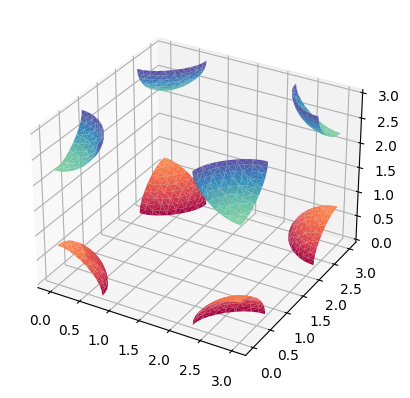

In [ ]:
#(Source: https://stackoverflow.com/questions/6030098/how-to-display-a-3d-plot-of-a-3d-array-isosurface-in-matplotlib-mplot3d-or-simil)
import numpy as np
from numpy import cos, pi
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x, y, z = pi*np.mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
vol = cos(x) + cos(y) + cos(z)
iso_val=-2.0

verts, faces, _, _ = marching_cubes(vol, iso_val, spacing=(0.1, 0.1, 0.1))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], cmap='Spectral',lw=1)
#plt.show()

##### Generate Isosurface for the same test dataset using our implementation and generate interactive visualization.

In [ ]:
from itkwidgets import view, compare, cm
from numpy import cos, pi
import itkwidgets
import pyvista as pv
import vtk

cache={}
badset=set()
x, y, z = pi*np.mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
vol = cos(x) + cos(y) + cos(z)
iso_val=-2.0
verts,faces=getContourSegments(iso_val,vol)

#vol
celltypes = np.empty(faces.shape[0], dtype=np.uint8)
celltypes[:] = vtk.VTK_TRIANGLE
grid = pv.UnstructuredGrid(faces.ravel(), celltypes, verts)
# call itkwidget
view(geometries=grid)



Time taken by algorithm
----------------------------------------
0.0778498649597168 s


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

##### Another comparision - this time for an ellipsod.

In [ ]:
# Source: https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

AttributeError: module 'skimage.measure' has no attribute 'marching_cubes_lewiner'

##### Isosurface using our marching cubes implementation for ellipsoid

In [ ]:
ellip_base = ellipsoid(6, 10, 16, levelset=True)
vol = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)
cache={}
badset=set()
iso_val=0
verts,faces=getContourSegments(iso_val,vol)

#vol
celltypes = np.empty(faces.shape[0], dtype=np.uint8)
celltypes[:] = vtk.VTK_TRIANGLE
grid = pv.UnstructuredGrid(faces.ravel(), celltypes, verts)
# call itkwidget
view(geometries=grid)


Time taken by algorithm
----------------------------------------
0.12261295318603516 s


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

##### Interactive Visualization for a CT Scan dataset
Now, run the algorithm for a CT scan dataset and generate interactive visualizations using Pyvista.

In [ ]:
from itkwidgets import view, compare, cm
from numpy import cos, pi
import itkwidgets
import pyvista as pv
import vtk
readdata, header = nrrd.read("CTA-cardio.nrrd") #File Source: https://www.slicer.org/wiki/File:CTA-cardio.nrrd

cache={}
badset=set()
iso_val=200
verts,faces=getContourSegments(iso_val,readdata)


#vol
celltypes = np.empty(faces.shape[0], dtype=np.uint8)
celltypes[:] = vtk.VTK_TRIANGLE
grid = pv.UnstructuredGrid(faces.ravel(), celltypes, verts)
# call itkwidget
view(geometries=grid)